In [249]:
import numpy as np
import matplotlib.pyplot as plt


### Function definitions

In [250]:

# Function to generate Ricker wavelet
def ricker_wavelet(t, f0):
    return (1 - 2 * (np.pi * f0 * t) ** 2) * np.exp(-(np.pi * f0 * t) ** 2)

# Function to compute Fourier spectrum
def fourier_spectrum(signal, dt):
    n = len(signal)
    freq = np.fft.fftfreq(n, d=dt)
    spectrum = np.fft.fft(signal)
    return freq, np.abs(spectrum)

#Function to define subsurface rupture length acc to emprical relationship from wells & coppersmith 1994 (Figure 14a)
def rld(M):
    #M = 4.38 + 1.49*np.log10(rld) 
    rld=10**((M-4.38)/1.49)
    return(rld)

#Function to define subsurface rupture width acc to emprical relationship from wells & coppersmith 1994 (Figure 15a)
def wid(M):
    #M = 4.06 + 2.25*np.log10(wid)
    wid=10**((M-4.06)/2.25)
    return(wid)

#Function to define avergae rise time acc to Graves & Pitarka 2010 equation 8
def avgrt(M0_dynecm):
    avg_rt=alpha*(1.6*10**(-9))*(M0_dynecm**(1/3))
    return avg_rt


# Define the piecewise slip rate function Liu et al., 2006 equation 7
def slip_rate_function(t, rt):
    t1 = 0.13*rt  # Define a time scale s
    t2= rt-t1
    pi = np.pi
    C=pi / (1.4 * pi * t1 + 1.2 * t1 + 0.3 * pi * t2)
    slip_rate = np.zeros_like(t)
    
    # Case 1: 0 <= t < t1
    mask1 = (t >= 0) & (t < t1)
    slip_rate[mask1] = C * (0.7 - 0.7 * np.cos(pi * t[mask1] / t1) + 0.6 * np.sin(0.5 * pi * t[mask1] / t1))
    
    # Case 2: t1 <= t < 2s
    mask2 = (t >= t1) & (t < 2 * t1)
    slip_rate[mask2] = C * (1.0 - 0.7 * np.cos(pi * t[mask2] / t1) + 0.3 * np.cos(pi * (t[mask2] - t1) / t2))
    
    # Case 3: 2s <= t < 3s
    mask3 = (t >= 2 *t1) & (t < rt)
    slip_rate[mask3] = C * (0.3 + 0.3 * np.cos(pi * (t[mask3] - t1) / t2))
    
    return slip_rate

### Liu et al. STF

In [251]:
rt_mw=[]
mws=[4.2,4.4,4.6,4.8,5.0,5.2]
for Mw in mws:
    print(f'************Mw = {Mw}**********')
    l=rld(Mw)
    w=wid(Mw)
    print(f'Rupture length is {l:.1f} km')
    print(f'Rupture width is {w:.1f} km')
    M0=10**((3/2)*Mw+9.05)
    M0_dynecm=M0*10**7
    print(f'Moment: {M0} N-m')

    mu=3*10**10
    Di=	M0/(mu*l*w*1e6);
    print(f'Average slip: {Di} m')

    avg_rt= avgrt(M0_dynecm)
    print(f'Avergae rise time = {avg_rt} s')
    
    rt_mw.append(avg_rt)

************Mw = 4.2**********
Rupture length is 0.8 km
Rupture width is 1.2 km
Moment: 2238721138568347.0 N-m
Average slip: 0.0854007907938425 m
Avergae rise time = 0.036977184058189644 s
************Mw = 4.4**********
Rupture length is 1.0 km
Rupture width is 1.4 km
Moment: 4466835921509653.0 N-m
Average slip: 0.10194004368820193 m
Avergae rise time = 0.046551516667445135 s
************Mw = 4.6**********
Rupture length is 1.4 km
Rupture width is 1.7 km
Moment: 8912509381337441.0 N-m
Average slip: 0.12168239205463789 m
Avergae rise time = 0.058604887290206284 s
************Mw = 4.8**********
Rupture length is 1.9 km
Rupture width is 2.1 km
Moment: 1.7782794100389228e+16 N-m
Average slip: 0.14524816745641966 m
Avergae rise time = 0.07377918186497374 s
************Mw = 5.0**********
Rupture length is 2.6 km
Rupture width is 2.6 km
Moment: 3.5481338923357604e+16 N-m
Average slip: 0.1733778387589154 m
Avergae rise time = 0.09288248691119887 s
************Mw = 5.2**********
Rupture length 

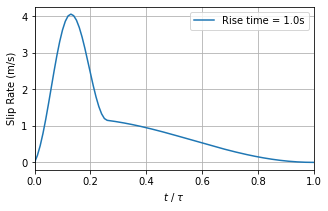

In [252]:
############plotting base function
# Parameters
rt=1.0
t = np.linspace(0, 10, 1000)  # Time array from 0 to 3s

plt.figure(figsize=(5, 3))
slip_rate = slip_rate_function(t, rt)
plt.plot(t, slip_rate, label=f'Rise time = {rt}s')
plt.title('')
plt.xlim(0,1)
plt.xlabel(r'$t$ $/$ $\tau$')
plt.ylabel('Slip Rate (m/s)')
plt.grid(True)
plt.legend()

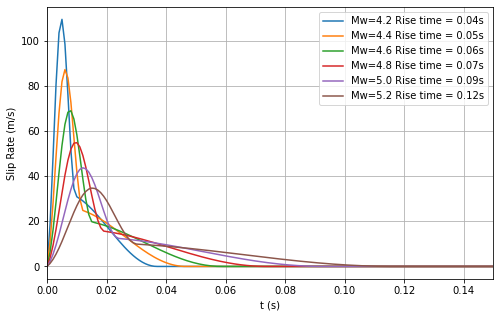

In [253]:



# Parameters
rt=0.1
sr=1000 #sampling rate
t = np.linspace(0, 1, sr)  # Time array from 0 to 3s
dt = 1/sr # Time step (in seconds)

plt.figure(figsize=(8, 5))
for i,rt in enumerate(rt_mw):
    # Compute the slip rate function
    slip_rate = slip_rate_function(t, rt)
    # Plot the slip rate function
    plt.plot(t, slip_rate, label=f'Mw={mws[i]} Rise time = {rt:.2f}s')
    plt.title('')
    plt.xlim(0,0.15)
    plt.xlabel('t (s)')
    plt.ylabel('Slip Rate (m/s)')
    plt.grid(True)
    plt.legend()


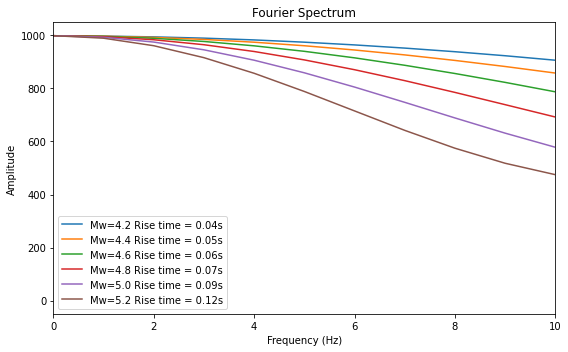

In [254]:
plt.figure(figsize=(8, 5))
for i,rt in enumerate(rt_mw):
    slip_rate = slip_rate_function(t, rt)
    freq, spectrum = fourier_spectrum(slip_rate, dt)
    plt.plot(np.fft.fftshift(freq), np.fft.fftshift(spectrum),label=f'Mw={mws[i]} Rise time = {rt:.2f}s')
plt.xlim(0,10)
plt.legend()
plt.title('Fourier Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


### Ricker source time function (STF)

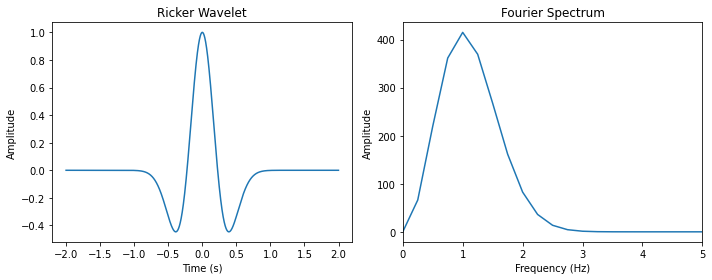

In [234]:

# Parameters
f0 = 1 # Peak frequency of the Ricker wavelet (in Hz)
dt = 0.001  # Time step (in seconds)
t = np.arange(-2, 2, dt)  # Time vector

# Generate Ricker wavelet
ricker = ricker_wavelet(t, f0)

# Compute Fourier spectrum
freq, spectrum = fourier_spectrum(ricker, dt)

# Plot the Ricker wavelet
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(t, ricker)
plt.title('Ricker Wavelet')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the Fourier spectrum
plt.subplot(1, 2, 2)
plt.plot(np.fft.fftshift(freq), np.fft.fftshift(spectrum))
plt.xlim(0,5)
plt.title('Fourier Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


In [200]:
### for gorkha
# Given Mw

#dep=20 ## vertical extent of the fault
#l=5 #km
#theta=11 #dip
#w=dep/np.sin(np.radians(theta)) #km
#print(f'Dimensions of the fault plane is {l} km X {w:.1f} km')